In [17]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

from scipy.stats import ttest_ind, mannwhitneyu
import datetime
import seaborn as sns 
import pandas as pd

In [18]:
def is_random_concept(concept, random_counterpart=None, random_concepts=None):
    if random_counterpart:
        return random_counterpart == concept

    elif random_concepts:
        return concept in random_concepts

    else:
        return 'random500_' in concept

def summarize_results(results):
    summary = {}
    random_results = {}

    for result in results:
        concept = result['cav_concept']
        bottleneck = result['bottleneck']

        if concept not in summary:
            summary[concept] = {}
        if bottleneck not in summary[concept]:
            summary[concept][bottleneck] = []

        summary[concept][bottleneck].append(result)

        if is_random_concept(concept):
            if bottleneck not in random_results:
                random_results[bottleneck] = []

            random_results[bottleneck].append(result['i_up'])

    return summary, random_results

def get_tcav_results(summary, random_results, min_p_val=0.05):
    columns = ['concept', 'bottleneck', 'score', 'random_score', 'p_value', 'significant']
    results_df = pd.DataFrame(columns=columns)

    for concept in summary:
        if not is_random_concept(concept):
            for bottleneck in summary[concept]:
                scores = [item['i_up'] for item in summary[concept][bottleneck]]
                _, p_val = mannwhitneyu(random_results[bottleneck], scores)
                significant = p_val <= min_p_val
                data = {'concept': concept, 'bottleneck': bottleneck,
                        'score': np.mean(scores), 'random_score': np.mean(random_results[bottleneck]),
                        'p_value': p_val, 'significant': significant}
                results_df = pd.concat([results_df, pd.DataFrame(data, index=[0])], ignore_index=True)

    return results_df

def merge_left_right_results(df):
    output_df = pd.DataFrame(columns=['concept', 'bottleneck', 'lh_score', 'rh_score', 'random_score', 'lh_p', 'rh_p'])
    
    assert all([concept.endswith('-lh') or concept.endswith('-rh') for concept in df['concept'].unique()])

    for row in df[df['concept'].str.endswith('-lh')].itertuples():
        row_dict = row._asdict()
        concept_name = row_dict['concept'][:-3]
        bottleneck = row_dict['bottleneck']
        lh_score = row_dict['score']
        lh_p = row_dict['p_value']
        lh_random_score = row_dict['random_score']

        rh_row = df[(df['concept'] == concept_name + '-rh') & (df['bottleneck'] == bottleneck)]
        
        if len(rh_row) == 0:
            print("No right hemisphere result for", concept_name, bottleneck)
            continue
        elif len(rh_row) > 1:
            print("More than one right hemisphere result for", concept_name, bottleneck)
            assert False
        
        rh_score = rh_row['score'].values[0]
        rh_p = rh_row['p_value'].values[0]
        rh_random_score = rh_row['random_score'].values[0]
    
        assert lh_random_score == rh_random_score

        data = {'concept': concept_name, 'bottleneck': bottleneck,
                'lh_score': lh_score, 'rh_score': rh_score, 'random_score': lh_random_score,
                'lh_p': lh_p, 'rh_p': rh_p}
        
        output_df = pd.concat([output_df, pd.DataFrame(data, index=[0])], ignore_index=True)

    return output_df

def move_left_right_to_colomn(df):
    columns = ['concept', 'bottleneck', 'score', 'random_score', 'p_value', 'significant', 'hemi']
    output_df = pd.DataFrame(columns=columns)
    
    assert all([concept.endswith('-lh') or concept.endswith('-rh') for concept in df['concept'].unique()])
    
    for row in df.itertuples():
        row_dict = row._asdict()
        
        concept_name = row_dict['concept'][:-3]
        bottleneck = row_dict['bottleneck']
        score = row_dict['score']
        random_score = row_dict['random_score']
        p_value = row_dict['p_value']
        significant = row_dict['significant']
        hemi = row_dict['concept'][-2:]       
        
        data = {'concept': concept_name, 'bottleneck': bottleneck,
                'score': score, 'random_score': random_score,
                'p_value': p_value, 'significant': significant, 'hemi': hemi}
        
        output_df = pd.concat([output_df, pd.DataFrame(data, index=[0])], ignore_index=True)
        
    return output_df
                
def present_results(result_summary, random_i_ups, min_p_val=0.05):
    for concept in result_summary:

        # if not random
        if not is_random_concept(concept):
            print(" ", "Concept =", concept)

            for bottleneck in result_summary[concept]:
                i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]

                # Calculate statistical significance
                _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)

                print(3 * " ", "Bottleneck =", ("%s. TCAV Score = %.2f (+- %.2f), "
                                                "random was %.2f (+- %.2f). p-val = %.3f (%s)") % (
                        bottleneck, np.mean(i_ups), np.std(i_ups),
                        np.mean(random_i_ups[bottleneck]),
                        np.std(random_i_ups[bottleneck]), p_val,
                        "not significant" if p_val > min_p_val else "significant"))

In [19]:
from matplotlib.patches import Patch

def plot_tcav_left_right(df, title='TCAV scores for each concept and bottleneck'):

    def format_string(s):
        space_idxs = [i for i, c in enumerate(s) if c == ' ']
        return s[:space_idxs[len(space_idxs)//2]] + '\n' + s[space_idxs[len(space_idxs)//2]+1:]
        

    tab10 = plt.get_cmap('tab10').colors

    fig, ax = plt.subplots(figsize=(15, 5))

    positions = np.array([ 0. ,  2.5,  5. ,  7.5, 10. ])
    min_pos = -0.5
    max_pos = float('-inf')

    xticks = []

    # Hline at 0.5 behind bars
    ax.axhline(0.5, color='k', linestyle='--', zorder=-1, alpha=0.5)

    for i, concept in enumerate(df['concept'].unique()):
        for j, bottleneck in enumerate(df[df['concept'] == concept]['bottleneck']):
            x = 15*i + positions[j]
            
            data = df[(df['concept'] == concept) & (df['bottleneck'] == bottleneck)]
            
            y1 = data['lh_score'].values[0]
            y2 = data['rh_score'].values[0]
            
            # Make two bars side by side with y1 and y2 values in different patterns
            ax.bar(x - 0.5, y1, width=1, color=tab10[j], edgecolor='k', hatch='xxx')
            ax.bar(x + 0.5, y2, width=1, color=tab10[j], edgecolor='k', hatch='...')
            
            lh_p = data['lh_p'].values[0]
            rh_p = data['rh_p'].values[0]
            
            # Add '*' above the bar if the score is significant
            if lh_p < 0.05:
                ax.text(x - 0.5, y1, '*', fontsize=10, horizontalalignment='center')
            if rh_p < 0.05:
                ax.text(x + 0.5, y2, '*', fontsize=10, horizontalalignment='center')        
            
            max_pos = max(max_pos, x + 0.5)        
            
        xticks.append(np.mean(15*i + positions))
        
    xtickslabels = df['concept'].unique()
    xtickslabels = [format_string(label.replace('Alpha_', '')) for label in xtickslabels]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtickslabels, rotation=0, fontsize=10)

    # Make legend with colors and bottlenecks names. Make it one row
    legend_elements = [Patch(facecolor=tab10[i], edgecolor='k', label=bottleneck) for i, bottleneck in enumerate(df['bottleneck'].unique())]
    legend1 = plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0, 1), ncol=5, fontsize=10)

    # Add an extra legend without removing the previous one
    legend_elements = [Patch(facecolor='w', edgecolor='k', hatch='xx', label='Left hemisphere'),
                        Patch(facecolor='w', edgecolor='k', hatch='..', label='Right hemisphere')]
    legend2 = plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), ncol=5, fontsize=10)

    # Add both legends to the plot
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.set_ylim(0, 1.1)
    ax.set_yticks(np.arange(0, 1.1, 0.2))
    ax.set_ylabel('TCAV score', fontsize=12)

    ax.set_xlim(min_pos - 1.5, max_pos + 1.5)

    plt.suptitle(title, fontsize=16, y=0.95)
    plt.show()


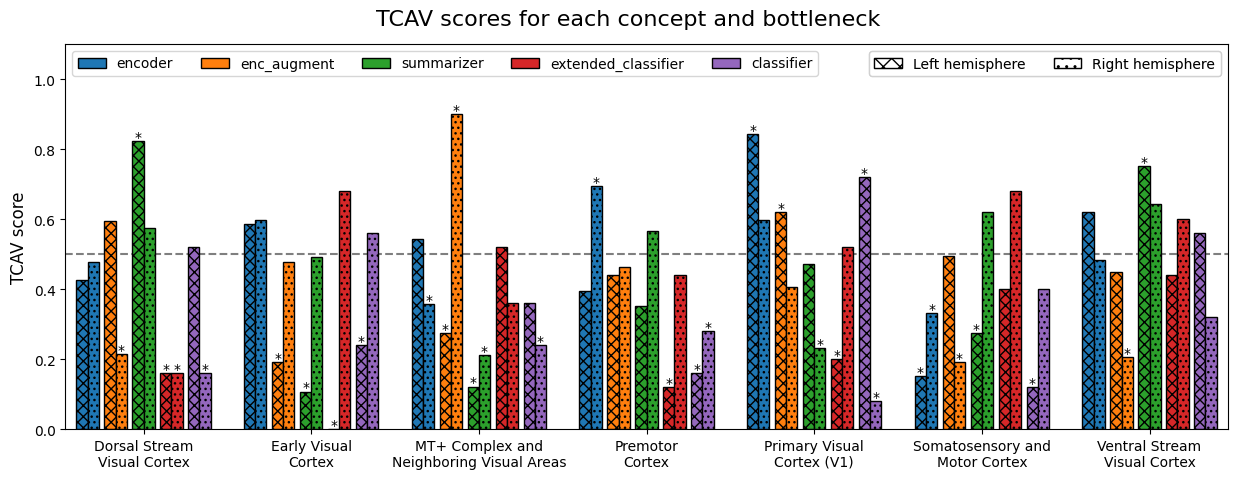

In [15]:
result_path = 'data/tcav_results_0502223524939809_TUH_clean_all_divide_Falsesigma_Falseabs_100.0_210702_010523_25.pkl'
with open(result_path, 'rb') as f:
    results = pickle.load(f)
    
results = sorted(results, key=lambda k: k['cav_concept'])

result_summary, random_i_ups = summarize_results(results)
df = get_tcav_results(result_summary, random_i_ups)
df_merge = merge_left_right_results(df)
df_extra = move_left_right_to_colomn(df)

plot_tcav_left_right(df_merge)


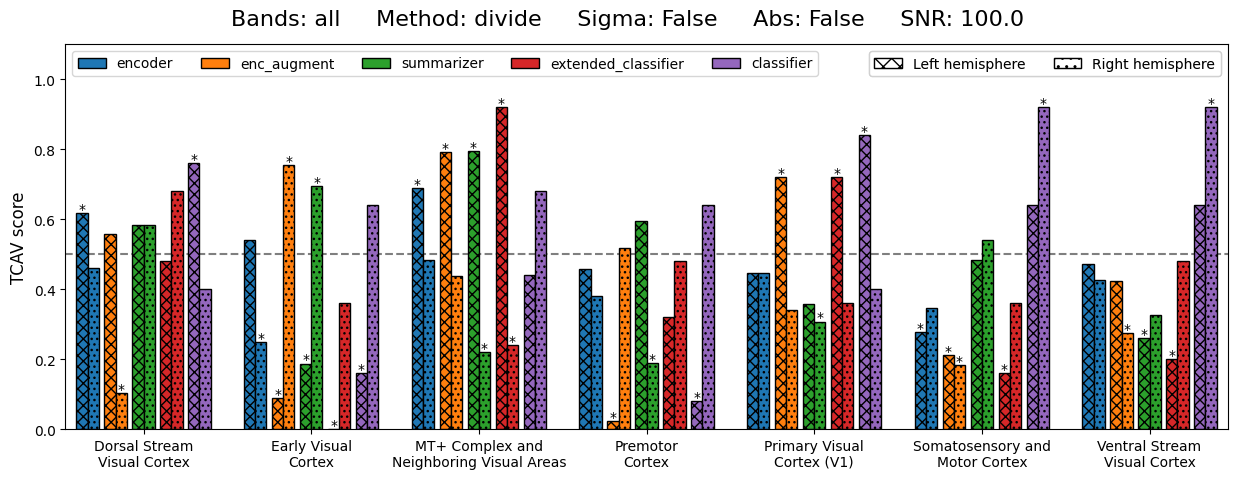

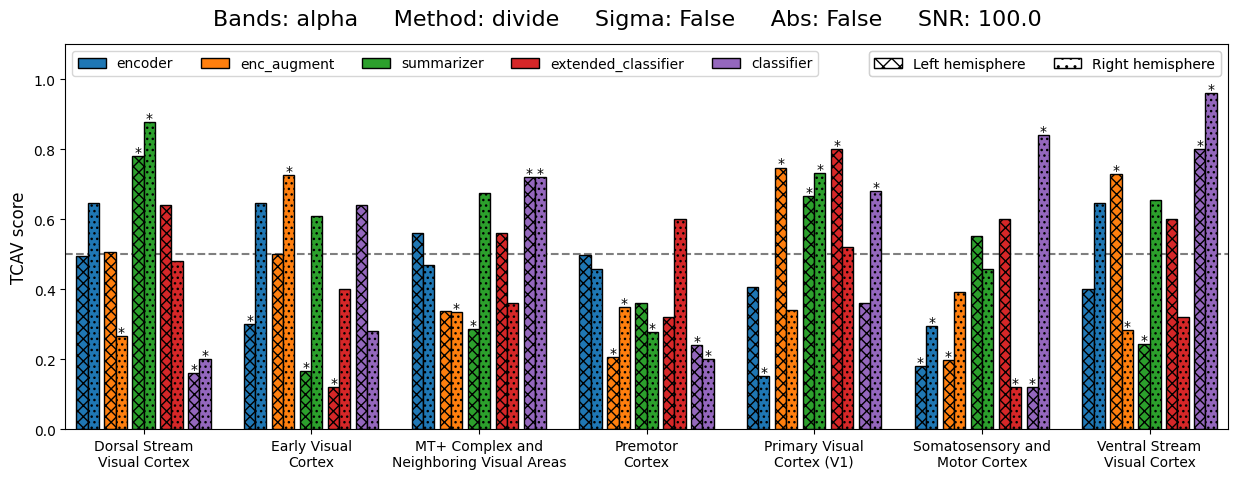

Skipping all_divide_Falsesigma_Falseabs_100.0


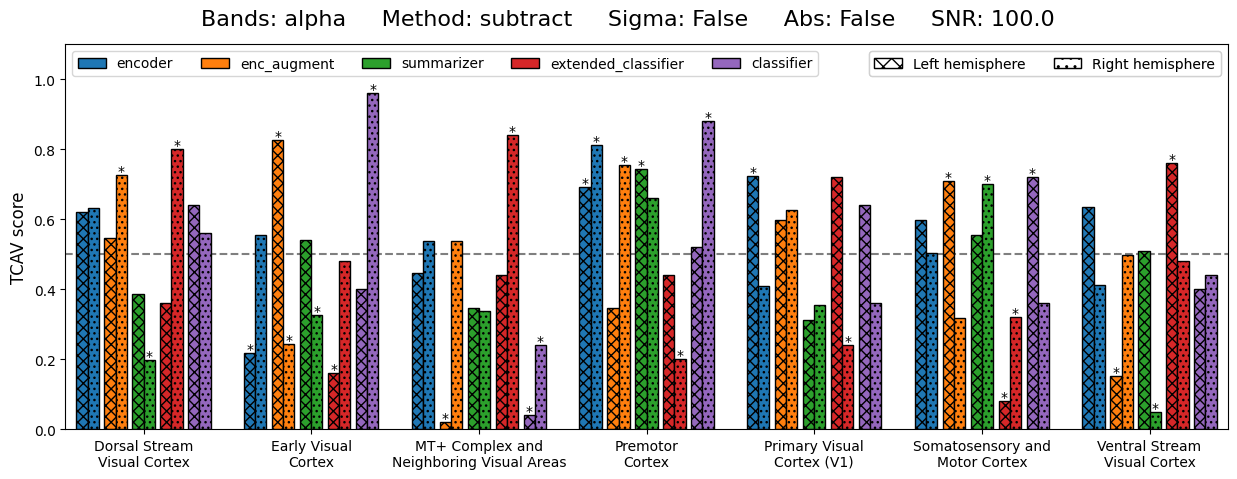

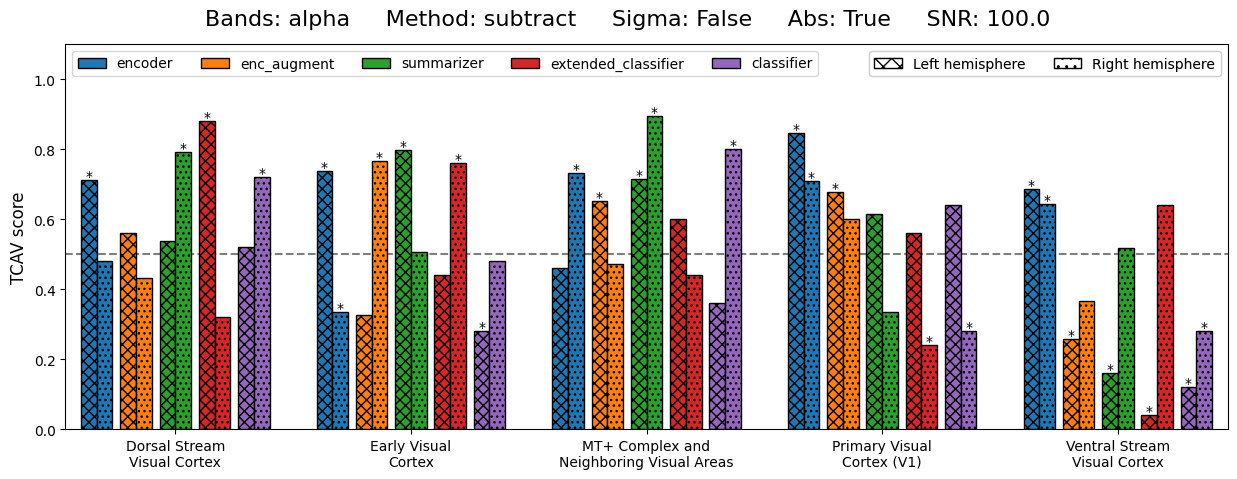

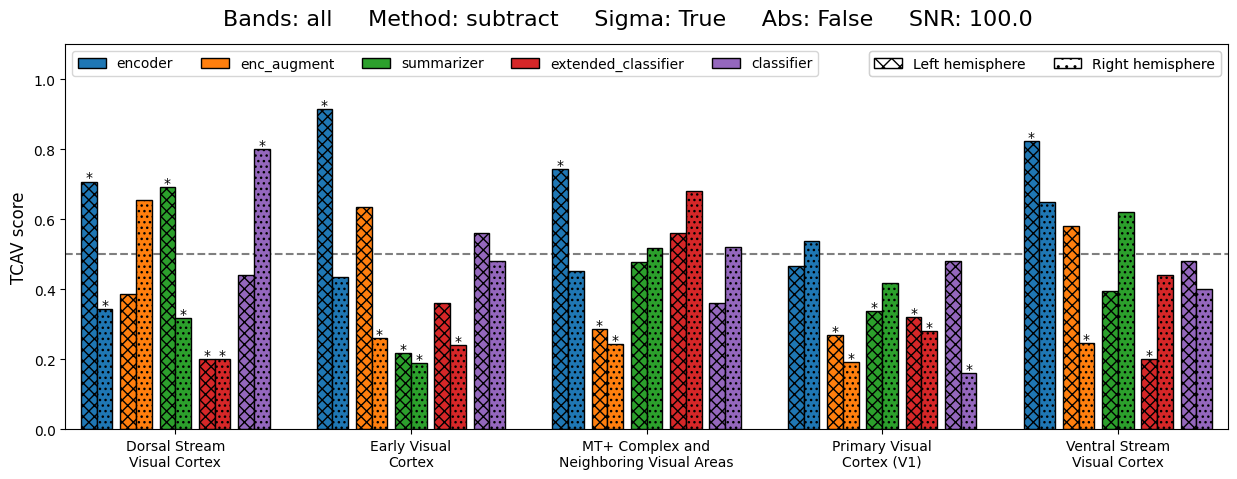

No right hemisphere result for Alpha_Early Visual Cortex encoder
No right hemisphere result for Alpha_Early Visual Cortex enc_augment
No right hemisphere result for Alpha_Early Visual Cortex summarizer
No right hemisphere result for Alpha_Early Visual Cortex extended_classifier
No right hemisphere result for Alpha_Early Visual Cortex classifier


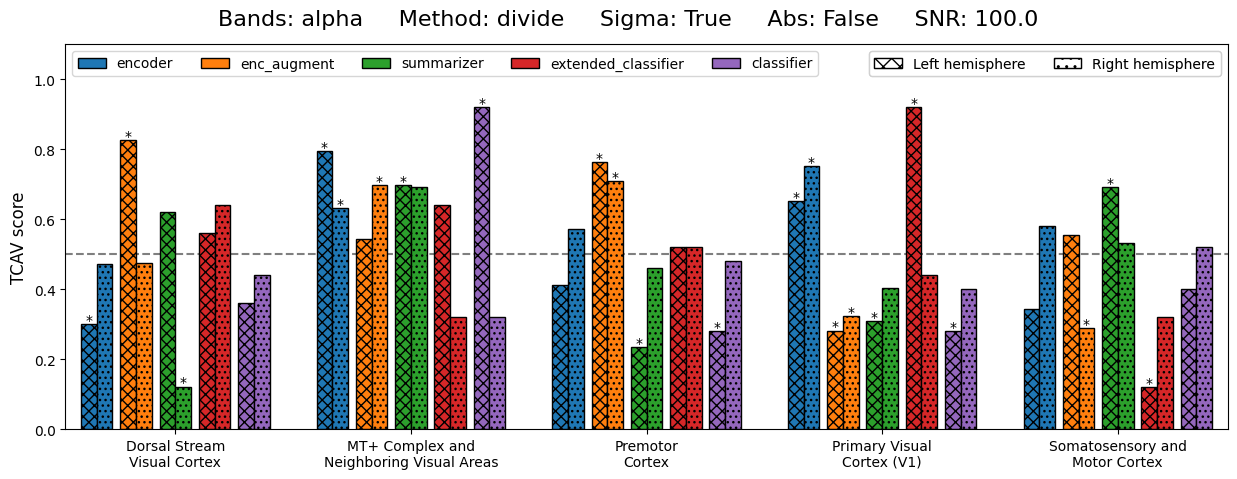

Skipping all_divide_Falsesigma_Falseabs_100.0
Skipping all_divide_Falsesigma_Falseabs_100.0
Skipping all_divide_Falsesigma_Falseabs_100.0
No right hemisphere result for Alpha_Early Visual Cortex encoder
No right hemisphere result for Alpha_Early Visual Cortex enc_augment
No right hemisphere result for Alpha_Early Visual Cortex summarizer
No right hemisphere result for Alpha_Early Visual Cortex extended_classifier
No right hemisphere result for Alpha_Early Visual Cortex classifier
No right hemisphere result for Alpha_Ventral Stream Visual Cortex encoder
No right hemisphere result for Alpha_Ventral Stream Visual Cortex enc_augment
No right hemisphere result for Alpha_Ventral Stream Visual Cortex summarizer
No right hemisphere result for Alpha_Ventral Stream Visual Cortex extended_classifier
No right hemisphere result for Alpha_Ventral Stream Visual Cortex classifier
tcav_results_0502223524813746_TUH_clean_all_subtract_Falsesigma_Falseabs_100.0_213033_010523_25
No right hemisphere result 

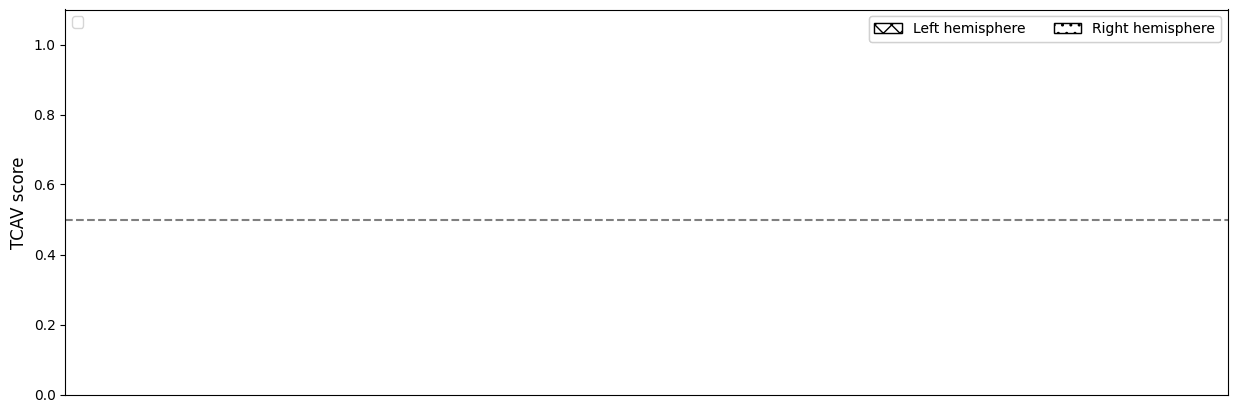

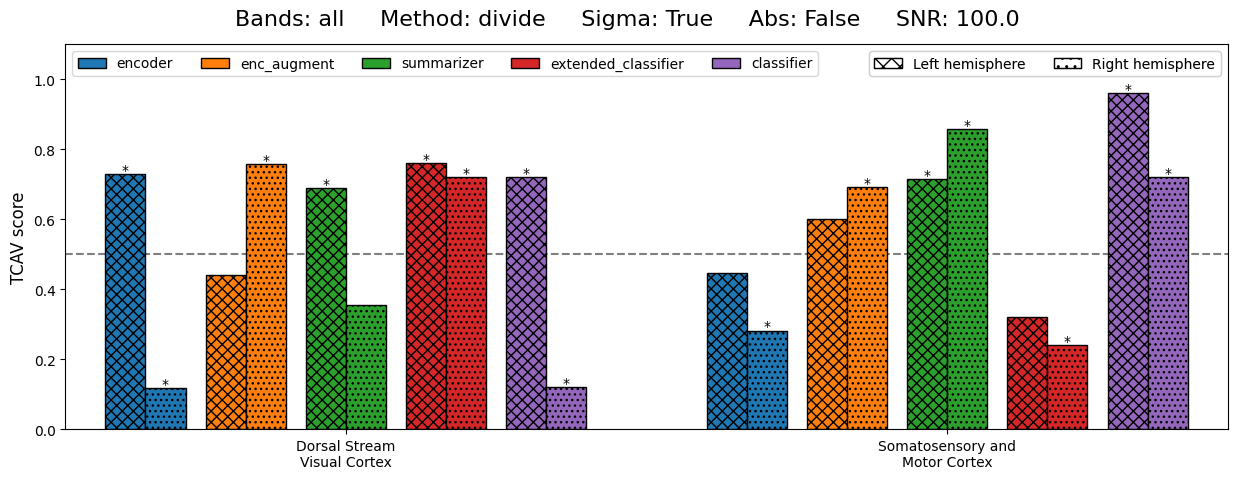

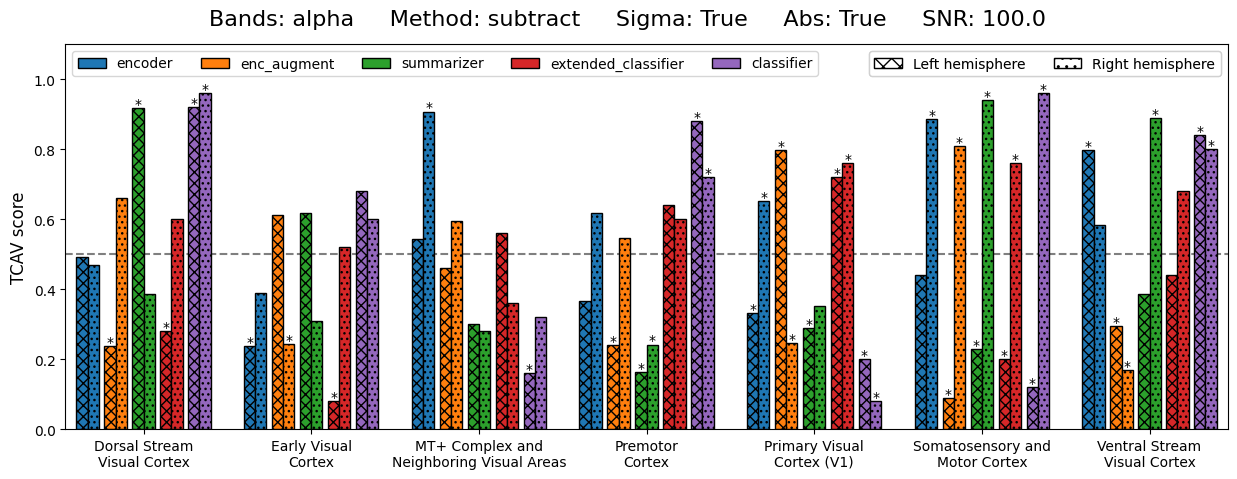

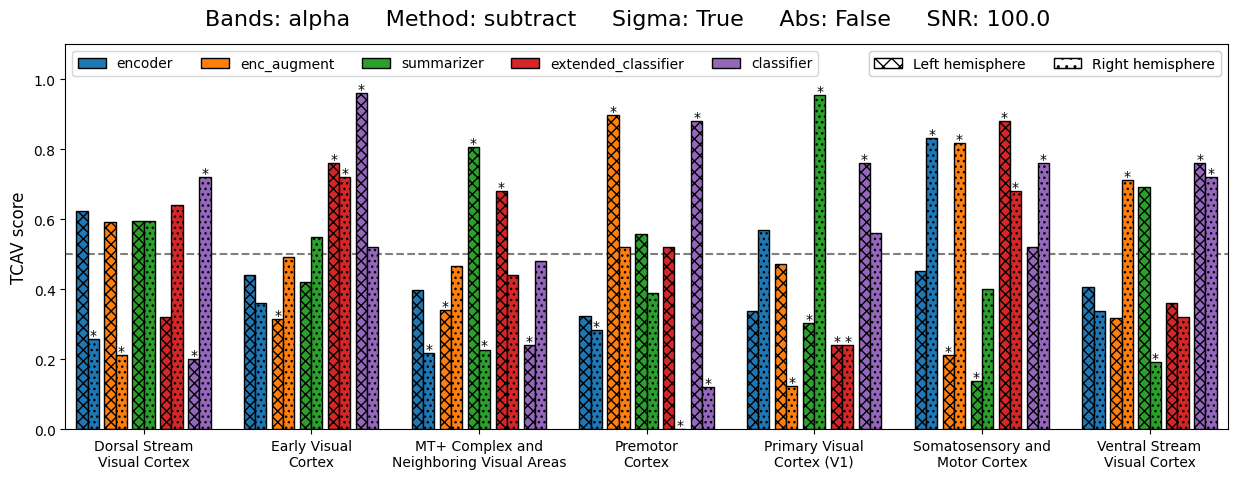

In [64]:
done = []

import random
random.seed(0)
files = os.listdir('data')
random.shuffle(files)

for file in files:
    if file.startswith('tcav_results') and 'imagined' not in file and '100.0' in file: #and 'TUH_clean_all_divide_Falsesigma_Falseabs' in file and '100.0' in file:
        try:
            result_path = 'data/' + file
            with open(result_path, 'rb') as f:
                results = pickle.load(f)
                
            results = sorted(results, key=lambda k: k['cav_concept'])

            result_summary, random_i_ups = summarize_results(results)
            df = get_tcav_results(result_summary, random_i_ups)
            df_merge = merge_left_right_results(df)
            
            #_, _, _, _, _,  a, b, c, d, e, _, _, _, _ = file.split('_')
            _, _, _, _, _,  a, b, c, d, e, _, _, _ = file.split('_')
            name = '_'.join([a, b, c, d, e])
            
            if name in done:
                print("Skipping", name)
                continue
            else:
                done.append(name)
            
            
            c = "True" if c == "Truesigma" else "False"
            d = "True" if d == "Trueabs" else "False"
            
            #df_extra = move_left_right_to_colomn(df)

            plot_tcav_left_right(df_merge, title=f"Bands: {a}     Method: {b}     Sigma: {c}     Abs: {d}     SNR: {e}")
        except:
            print(file)
            continue


In [8]:
results = []
for file in os.listdir('data'):
    if 'TUH_clean_all_divide_Falsesigma_Falseabs_100.0' in file:
        with open('data/' + file, 'rb') as f:
            results.append(pickle.load(f))

In [13]:
results = [item for sublist in results for item in sublist]

In [20]:
results = sorted(results, key=lambda k: k['cav_concept'])

result_summary, random_i_ups = summarize_results(results)
df = get_tcav_results(result_summary, random_i_ups)
df_merge = merge_left_right_results(df)

In [28]:
len(random_i_ups['encoder'])

3000

In [22]:
df_merge

,concept,bottleneck,lh_score,rh_score,random_score,lh_p,rh_p
0,Alpha_Dorsal Stream Visual Cortex,encoder,0.55040,0.41728,0.494680,6.296443e-02,9.585635e-03
1,Alpha_Dorsal Stream Visual Cortex,enc_augment,0.41952,0.31552,0.491200,9.564423e-02,9.704035e-06
2,Alpha_Dorsal Stream Visual Cortex,summarizer,0.58656,0.40608,0.501653,1.452850e-02,1.679493e-02
3,Alpha_Dorsal Stream Visual Cortex,extended_classifier,0.44800,0.39200,0.499667,2.577465e-01,1.834776e-02
4,Alpha_Dorsal Stream Visual Cortex,classifier,0.59200,0.40000,0.496667,3.677466e-02,3.420194e-02
5,Alpha_Early Visual Cortex,encoder,0.56032,0.42080,0.494680,6.284131e-02,5.544778e-02
6,Alpha_Early Visual Cortex,enc_augment,0.12832,0.57504,0.491200,5.745682e-23,1.536680e-02
7,Alpha_Early Visual Cortex,summarizer,0.21888,0.54816,0.501653,1.100225e-12,2.888354e-01
8,Alpha_Early Visual Cortex,extended_classifier,0.05600,0.51200,0.499667,2.359149e-22,7.870770e-01
9,Alpha_Early Visual Cortex,classifier,0.16000,0.54400,0.496667,1.595728e-13,2.998285e-01
